# Теория

Если посмотреть на то, как работает процессор, можно представить следующую схему:  
0) появляются инструкция вида "сложи числа a и b"  
1) берутся данные из оперативной памяти  
2) кладутся в регистры  
3) данные обрабатываются к математическом блоке  
4) результат кладется в новый регистр  
5) значение возвращается в оперативную память  

Пример инструкций:  
Load b, R1  
Load a, R2  
add R1, R2, R1

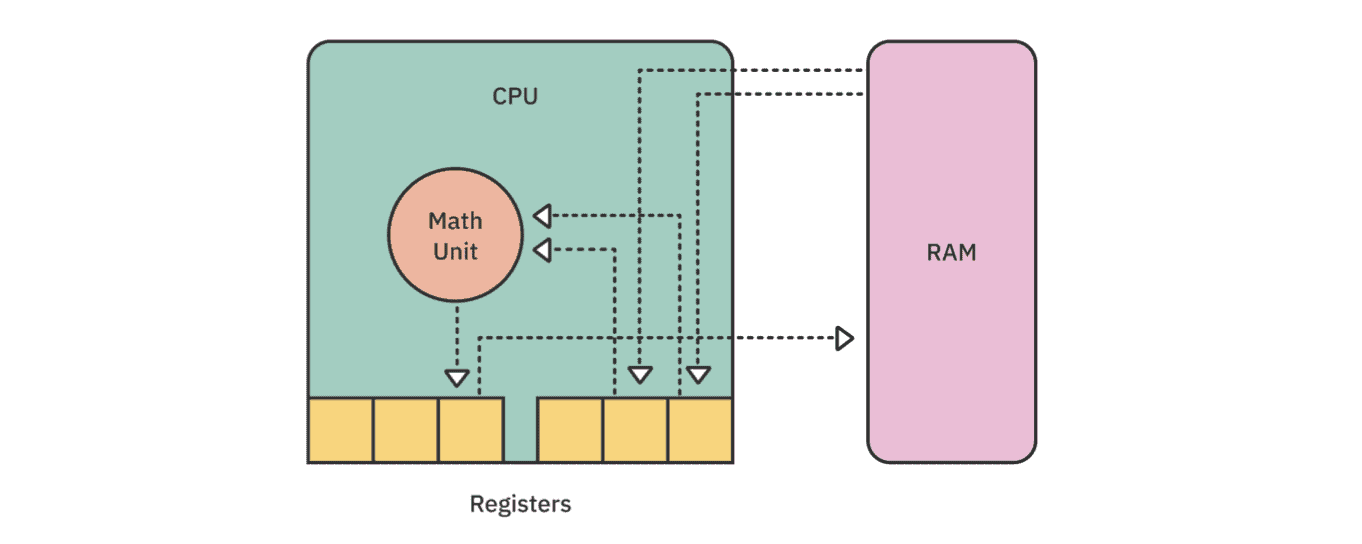

Иногда мы хотим выполнять сразу несколько частей кода за раз, в таком случае у нас есть 2 основных подхода:
- конкурентность
- параллелизм

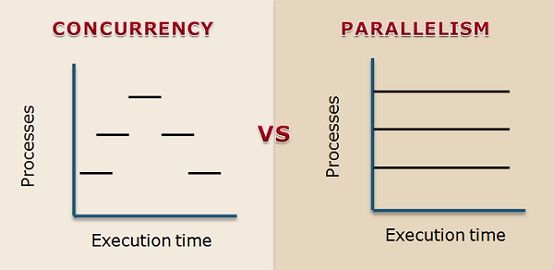

Конкурентность в питоне достигается тремя способами:  
1) асинхронность (asyncio)  
2) многопоточность (multithreading)  
3) мультипроцессинг (multiprocessing)  

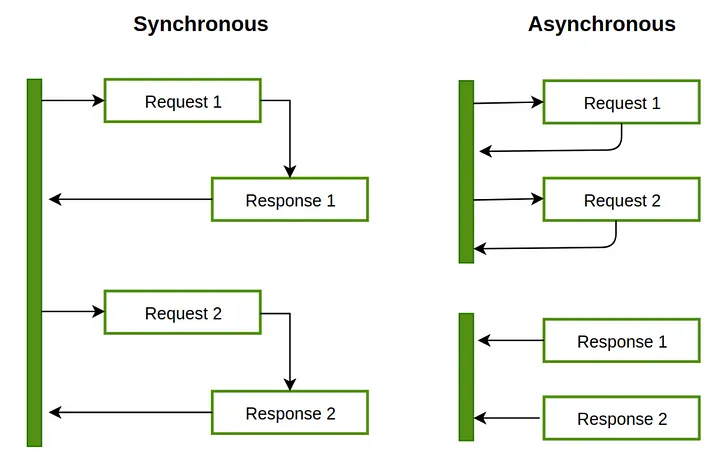

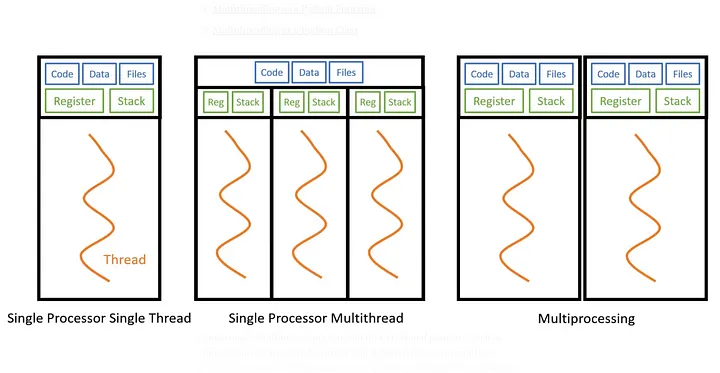

Для обеспечения работы процессов планировщик задач ОС решает задачу диспетчеризации:  
1) пришел триггер  
2) решаем, должна ли текущая задача продолжаться  
3) решаем последовательность задач  
4) сохраняем контекст задачи  
5) загружаем контекст новой задачи  
6) запускаем новую задачу

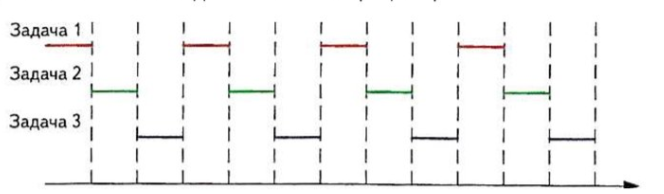

# Практика

## Наш простой код

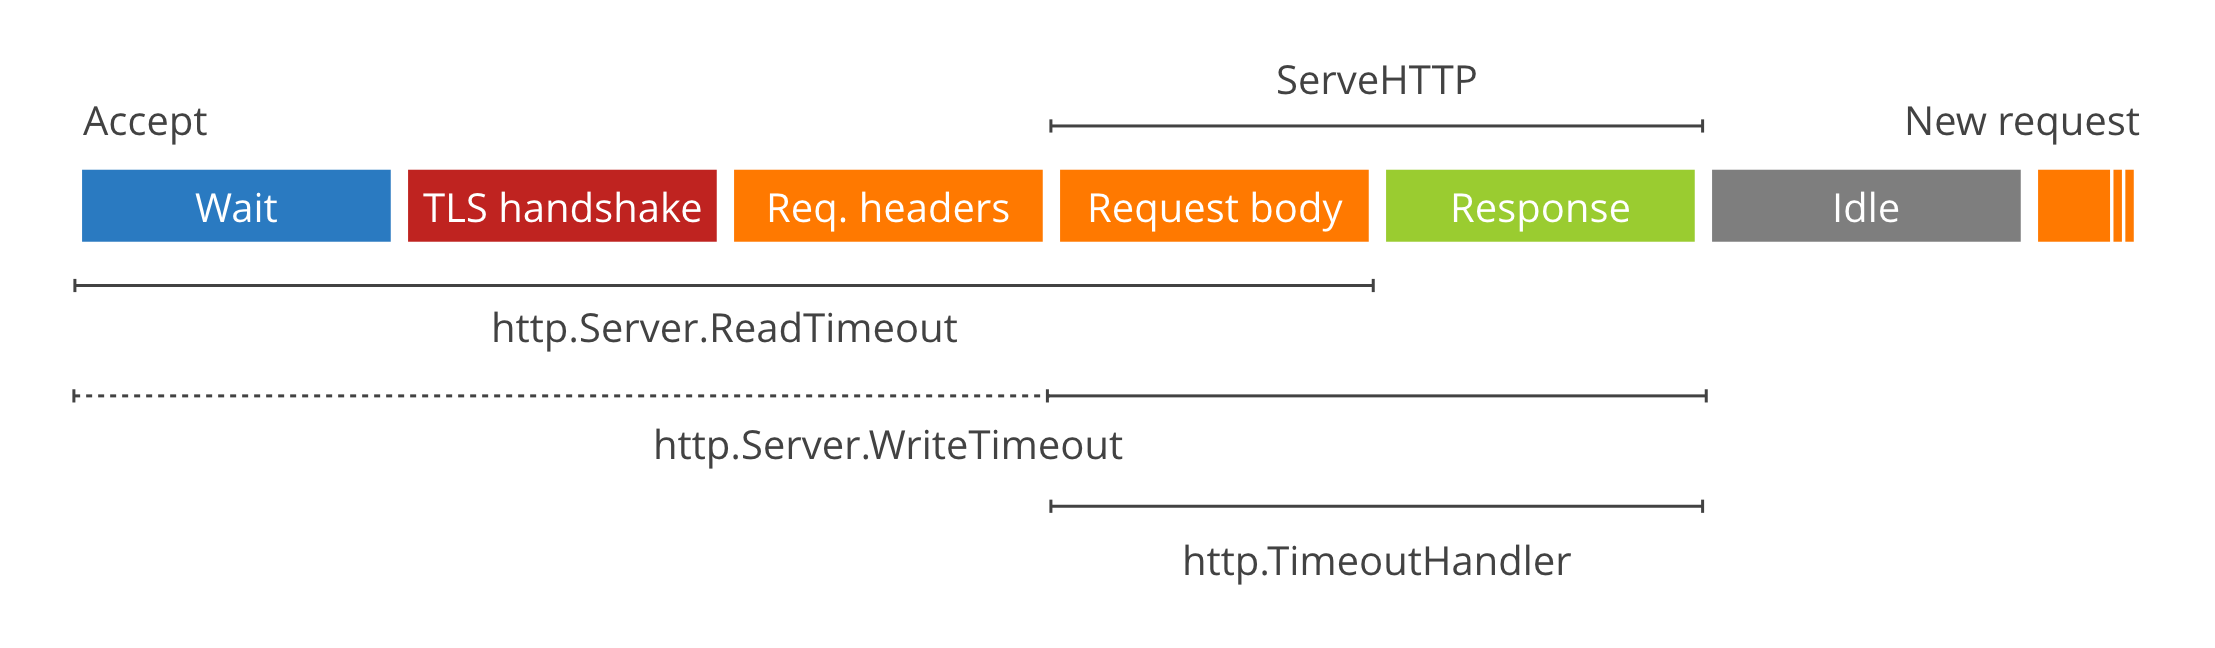

In [1]:
import requests

def download_file(filename, url):
  with open(filename, "wb") as f:
    with requests.get(url) as resp:
      f.write(resp.content)
  print(f"download of {filename} is completed")

def main():
    params = [("ordinary_dog1.jpg", "https://i.natgeofe.com/n/4f5aaece-3300-41a4-b2a8-ed2708a0a27c/domestic-dog_thumb_square.jpg"),
              ("ordinary_dog2.jpg", "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg")]
    for p in params:
      filename, url = p
      download_file(filename, url)

In [2]:
main()

download of ordinary_dog1.jpg is completed
download of ordinary_dog2.jpg is completed


## Асинхронность

Асинхронность позволяет нам конкурентно выполнять несколько задач в одном потоке, не блокируя основное выполнение программы

In [3]:
!pip install aiofile

In [22]:
import asyncio
import aiohttp
import aiofile

# для работы в колабе
import nest_asyncio
nest_asyncio.apply()

async def download_file(session, filename, url):
  async with aiofile.async_open(filename, "wb") as f:
    async with session.get(url) as resp:
      data = await resp.read()
      await f.write(data)
  print(f"download of {filename} is completed")

async def main():
  async with aiohttp.ClientSession() as session:
    tasks = [download_file(session, "async_dog1.jpg", "https://i.natgeofe.com/n/4f5aaece-3300-41a4-b2a8-ed2708a0a27c/domestic-dog_thumb_square.jpg"),
            download_file(session, "async_dog2.jpg", "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg")]
    await asyncio.gather(*tasks) # конкурентно выполняем то, что в нас подали, создавая таски

In [23]:
loop = asyncio.get_event_loop()
loop.run_until_complete(main())
# loop.close() # не в колабе
# теперь можно проверить файлы

/tmp/ipython-input-528892094.py:11: RuntimeWarning: coroutine 'ClientSession._request' was never awaited
  with session.get(url) as resp:


TypeError: '_BaseRequestContextManager' object does not support the context manager protocol

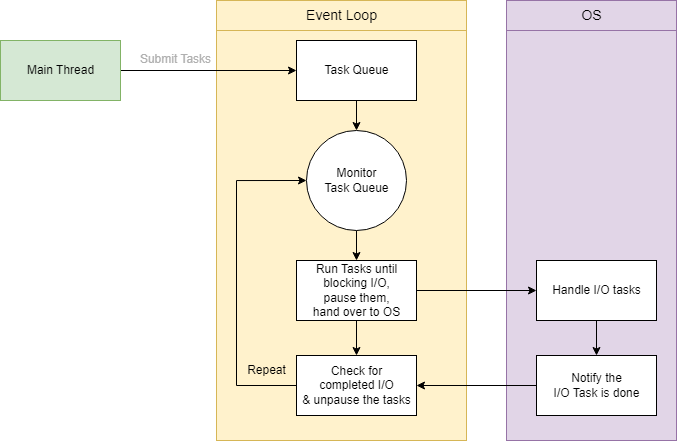

Что будет, если скомбинировать asyncio и обычный код?
Возьмем простую задачку, добавим там time.sleep(), будто б у нас долго что-то там работает

In [24]:
import time

In [25]:
%%time

def sleep():
    time.sleep(1)

def sum(name, numbers):
    total = 0
    for number in numbers:
        print(f'Task {name}: Computing {total}+{number}')
        sleep()
        total += number
    print(f'Task {name}: Sum = {total}\n')

tasks = [
    sum("A", [1, 2]),
    sum("B", [1, 2, 3]),
]

Task A: Computing 0+1
Task A: Computing 1+2
Task A: Sum = 3

Task B: Computing 0+1
Task B: Computing 1+2
Task B: Computing 3+3
Task B: Sum = 6

CPU times: user 7.65 ms, sys: 228 µs, total: 7.88 ms
Wall time: 5 s


In [27]:
%%time

def sleep():
    time.sleep(1)

async def sum(name, numbers):
    total = 0
    for number in numbers:
        print(f'Task {name}: Computing {total}+{number}')
        sleep()
        total += number
    print(f'Task {name}: Sum = {total}\n')

loop = asyncio.get_event_loop()
tasks = [
    loop.create_task(sum("A", [1, 2])),
    loop.create_task(sum("B", [1, 2, 3])),
]
loop.run_until_complete(asyncio.wait(tasks))

Task A: Computing 0+1
Task A: Computing 1+2
Task A: Sum = 3



TypeError: a coroutine was expected, got None

In [29]:
%%time
async def sleep(): # добавили async
    time.sleep(1)

async def sum(name, numbers): # добавили async
    total = 0
    for number in numbers:
        print(f'Task {name}: Computing {total}+{number}')
        await sleep() # добавили await
        total += number
    print(f'Task {name}: Sum = {total}\n')

loop = asyncio.get_event_loop()
tasks = [
    loop.create_task(sum("A", [1, 2])),
    loop.create_task(sum("B", [1, 2, 3])),
]
loop.run_until_complete(asyncio.wait(tasks))
# loop.close() # не в колабе

Task A: Computing 0+1
Task A: Computing 1+2
Task A: Sum = 3

Task B: Computing 0+1
Task B: Computing 1+2
Task B: Computing 3+3
Task B: Sum = 6

CPU times: user 6.18 ms, sys: 1.73 ms, total: 7.91 ms
Wall time: 5 s


({<Task finished name='Task-73' coro=<sum() done, defined at <timed exec>:4> result=None>,
  <Task finished name='Task-74' coro=<sum() done, defined at <timed exec>:4> result=None>},
 set())

In [30]:
%%time

async def sleep():
    await asyncio.sleep(1) # добавили asyncio.sleep()

async def sum(name, numbers):
    total = 0
    for number in numbers:
        print(f'Task {name}: Computing {total}+{number}')
        await sleep()
        total += number
    print(f'Task {name}: Sum = {total}\n')

loop = asyncio.get_event_loop()
tasks = [
    loop.create_task(sum("A", [1, 2])),
    loop.create_task(sum("B", [1, 2, 3])),
]
loop.run_until_complete(asyncio.wait(tasks))
# loop.close() # не в колабе

Task A: Computing 0+1
Task B: Computing 0+1
Task A: Computing 1+2
Task B: Computing 1+2
Task A: Sum = 3

Task B: Computing 3+3
Task B: Sum = 6

CPU times: user 4.93 ms, sys: 1.06 ms, total: 5.99 ms
Wall time: 3 s


({<Task finished name='Task-76' coro=<sum() done, defined at <timed exec>:4> result=None>,
  <Task finished name='Task-77' coro=<sum() done, defined at <timed exec>:4> result=None>},
 set())

## Многопоточность

In [31]:
import threading

def download_file(filename, url):
  with open(filename, "wb") as f:
    with requests.get(url) as resp:
      f.write(resp.content)
  print(f"download of {filename} is completed")

def main():
  params = [("thread_dog1.jpg", "https://i.natgeofe.com/n/4f5aaece-3300-41a4-b2a8-ed2708a0a27c/domestic-dog_thumb_square.jpg"),
            ("thread_dog2.jpg", "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg")]
  threads = []

  for p in params:
    filename, url = p
    thread = threading.Thread(target=download_file, args=[filename, url])
    threads.append(thread)

  for thread in threads:
    thread.start()

  print("all threads started")

  for thread in threads:
    thread.join() # ждем окончания

  print("all threads done")

In [32]:
main()

all threads started
download of thread_dog2.jpg is completed
download of thread_dog1.jpg is completed
all threads done


Что, если мы хотели бы производить конкурентно большое количество вычислений, но при это ограничить себя в ресурсах?

In [34]:
import concurrent.futures

In [36]:
%%time

def my_task(value):
  time.sleep(2)
  print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
   executor.map(my_task, range(10))

thread 0thread 1

thread 2
thread 3
thread 4
thread 5
thread 6
thread 7
thread 8
thread 9
CPU times: user 7.33 ms, sys: 2.12 ms, total: 9.45 ms
Wall time: 10 s


In [37]:
%%time

def my_task(value):
  time.sleep(2)
  print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
   executor.map(my_task, range(10))

thread 0
thread 1
thread 2
thread 3
thread 4
thread 5
thread 6
thread 7
thread 8
thread 9
CPU times: user 1.91 ms, sys: 1.73 ms, total: 3.64 ms
Wall time: 2 s


Если аргументы не получится подать в функцию, то ее просто пропустят, не выдав никакой ошибки:

In [38]:
%%time

def my_task():
  time.sleep(2)
  print("my thread")

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
   executor.map(my_task, range(10))

CPU times: user 1.39 ms, sys: 1.87 ms, total: 3.26 ms
Wall time: 6.07 ms


In [39]:
%%time

def my_task(params):
  name, value  = params
  time.sleep(2)
  print(f"thread {name}, value={value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
   executor.map(my_task, [(0, 0), (1, 4), (2, 12), (3, 7)])

thread 0, value=0
thread 1, value=4
thread 2, value=12thread 3, value=7

CPU times: user 2.55 ms, sys: 1.94 ms, total: 4.49 ms
Wall time: 4 s


Что будет, если мы хотим работать с одной и той же переменной?

In [41]:
class Account():
  def __init__(self, money):
    self.money = money

  def add(self, value):
    self.money += value

  def sub(self, value):
    self.money -= value

In [42]:
a = Account(100)

operations = [
    (a.add, 10),
    (a.sub, 80),
    (a.add, 5),
    (a.add, 60),
    (a.sub, 5),
]

threads = []
for op in operations:
  o, v = op
  thread = threading.Thread(target=o, args=[v])
  threads.append(thread)

for thread in threads:
  thread.start()

for thread in threads:
  thread.join() # ждем окончания

print(a.money)

90


In [ ]:
# 100 + 10 = 110
# 100 - 80 = 20

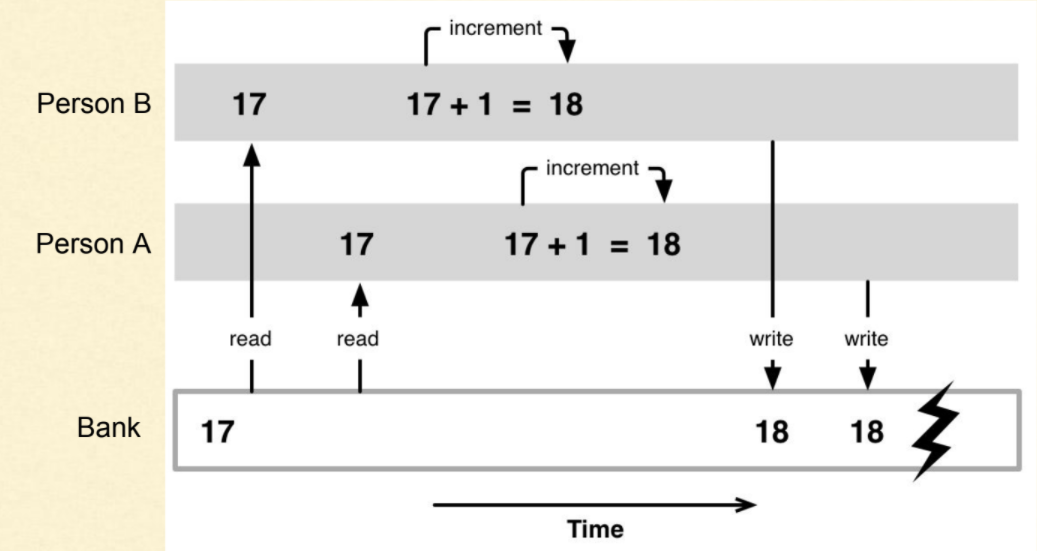

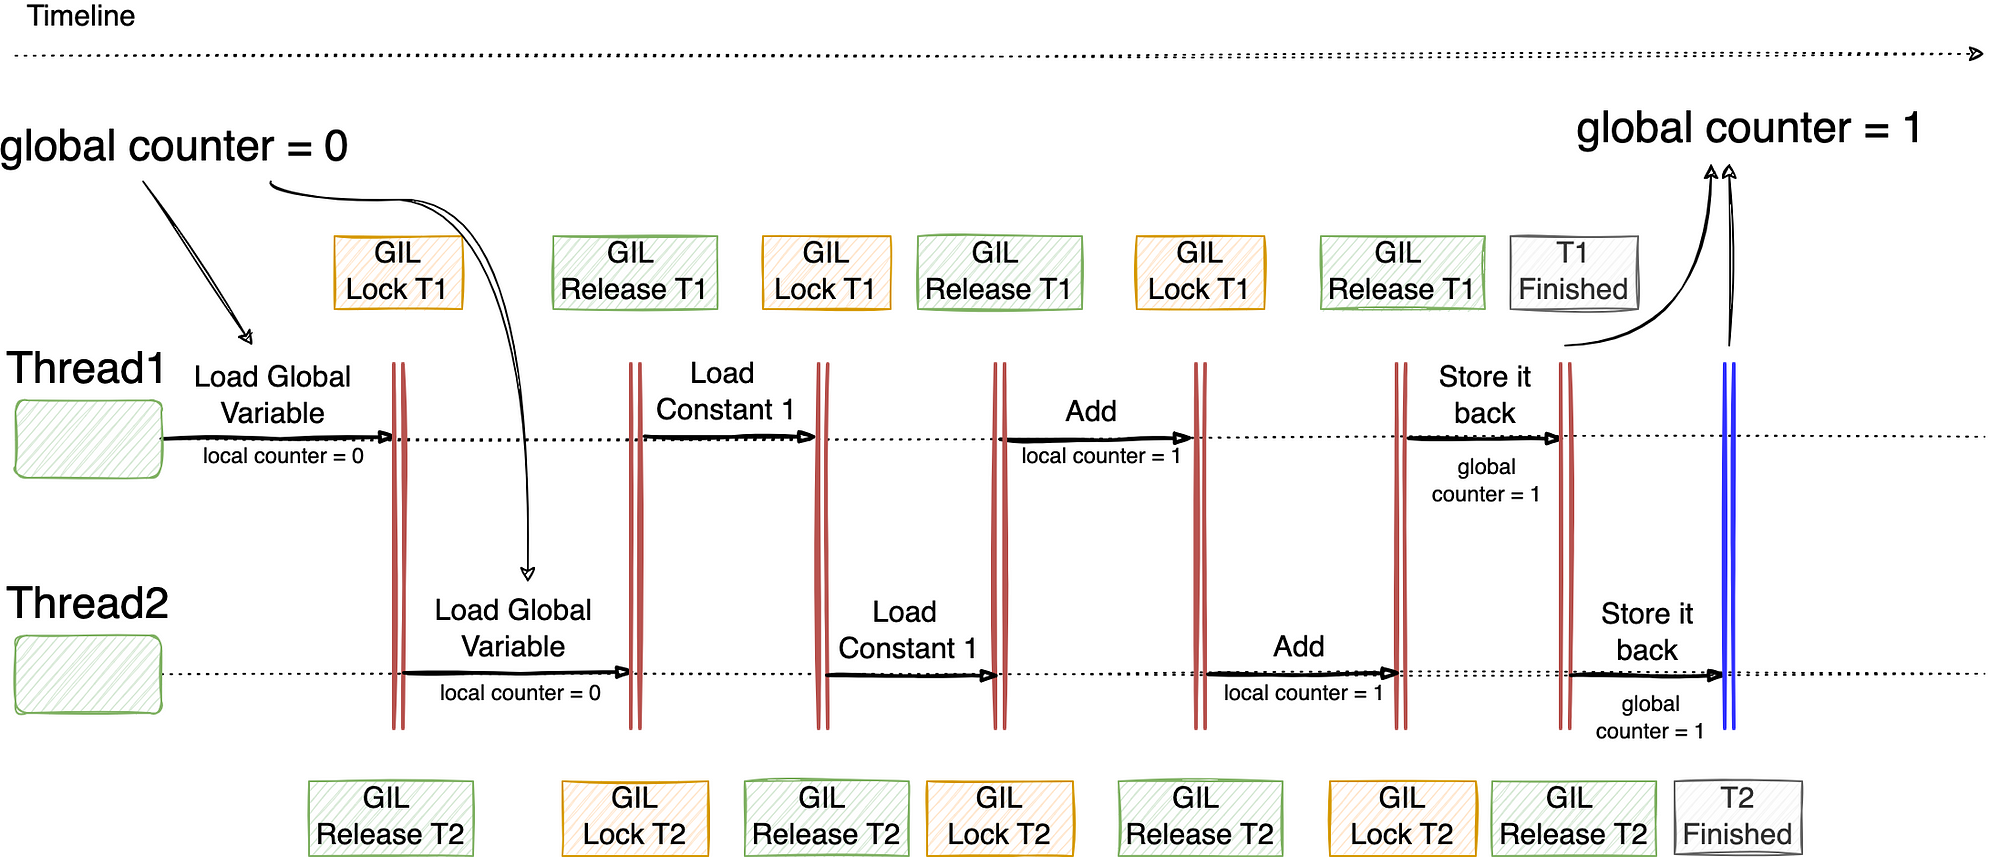

## Мультипроцессинг

In [43]:
import multiprocessing

# напоминалка, что написано выше
def download_file(filename, url):
  with open(filename, "wb") as f:
    with requests.get(url) as resp:
      f.write(resp.content)
  print(f"download of {filename} is completed")

def main():
  params = [("process_dog1.jpg", "https://i.natgeofe.com/n/4f5aaece-3300-41a4-b2a8-ed2708a0a27c/domestic-dog_thumb_square.jpg"),
            ("process_dog2.jpg", "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg")]
  processes  = []

  for p in params:
    filename, url = p
    process  = multiprocessing.Process(target=download_file, args=[filename, url])
    processes.append(process)

  for process in processes:
    process.start()

  print("all processes started")

  for process in processes:
    process.join() # ждем окончания

  print("all processes done")

In [44]:
main()

download of process_dog2.jpg is completed
download of process_dog1.jpg is completed
all processes started
all processes done


Попробуем поработать с одной и той же переменной

In [45]:
a = Account(100)

operations = [
    (a.add, 10),
    (a.sub, 80),
    (a.add, 5),
    (a.add, 60),
    (a.sub, 5),
]

processes = []
for op in operations:
  o, v = op
  process = multiprocessing.Process(target=o, args=[v])
  processes.append(process)

for process in processes:
  process.start()

for process in processes:
  process.join() # ждем окончания

print(a.money)

100


## Синхронизация

In [ ]:
# read A = 10
# write B = A + 1 = 11     # read A = 10
# write A = B = 11         # write B = A + 1 = 11
                           # write A = B = 11

# -----------------------------------------------
# write A+=1 = 11
#                          # write A+=1 = 12

Среди примитивов синхронизации можно выделить такие как:
- мьютекс
- семафор
- событие
- очередь

### Мьютекс (Lock)

Иногда при работе с общей переменной можно получить неожиданные результаты

In [50]:
counter = 0

def increment():
  global counter

  for _ in range(1000000):
      counter += int(1)


threads = []
for i in range(4):
  x = threading.Thread(target=increment)
  threads.append(x)

for t in threads:
  t.start()

for t in threads:
  t.join()

print(counter)

1628449


In [52]:
import atomics

In [53]:
counter = atomics.atomic(width=8, atype=atomics.INT)

def increment():
  global counter

  for _ in range(1000000):
      counter.inc()


threads = []
for i in range(4):
  x = threading.Thread(target=increment)
  threads.append(x)

for t in threads:
  t.start()

for t in threads:
  t.join()

print(counter)

AtomicInt(value=4000000, width=8, readonly=False, signed=True)


Для того, чтобы давать доступ к ресурсу в уникальном режиме нужен мьютекс

In [51]:
%%time
counter = 0

lock = threading.Lock()

def increment():
  global counter

  with lock:
    for _ in range(1000000):
      counter += int(1)



threads = []
for i in range(4):
  x = threading.Thread(target=increment)
  threads.append(x)

for t in threads:
  t.start()

for t in threads:
  t.join()

print(counter)

4000000
CPU times: user 499 ms, sys: 0 ns, total: 499 ms
Wall time: 501 ms


С мьютексом можно работать и в формате ContextManager'а, и просто вызывая его методы acquire() и release().  
С тем, где именно захватывать мьютекс, надо быть осторожным

In [54]:
%%time
counter = 0

lock = threading.Lock()

def increment():
  global counter

  for _ in range(1000000):
    lock.acquire()
    counter += int(1)
    lock.release()


threads = []
for i in range(4):
  x = threading.Thread(target=increment)
  threads.append(x)

for t in threads:
  t.start()

for t in threads:
  t.join()

print(counter)

4000000
CPU times: user 3.44 s, sys: 5.75 s, total: 9.19 s
Wall time: 6.66 s


In [57]:
%%time
counter = 0

lock = threading.Lock()

def increment():
  global counter

  lock.acquire()

  for _ in range(1000000):
    counter += int(1)

  lock.release()


threads = []
for i in range(4):
  x = threading.Thread(target=increment)
  threads.append(x)

for t in threads:
  t.start()

for t in threads:
  t.join()

print(counter)

4000000
CPU times: user 502 ms, sys: 0 ns, total: 502 ms
Wall time: 503 ms


Если где-то забыть релизнуть мьютекс, можно задедлочиться

In [55]:
lock = threading.Lock()
lock.acquire()
lock.acquire()

KeyboardInterrupt: 

### Семафор

Как мы помним, мы можем параллельно иметь несколько воркеров, что исполняют наши треды

In [58]:
%%time

def my_task(value):
  time.sleep(2)
  print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
   executor.map(my_task, range(10))

thread 0
thread 2
thread 1
thread 3thread 4

thread 5
thread 6
thread 8
thread 7
thread 9
CPU times: user 7.52 ms, sys: 2.08 ms, total: 9.6 ms
Wall time: 8 s


Но что, если они получают доступ к ограниченному ресурсу?

In [60]:
%%time

sem = threading.BoundedSemaphore(value=3)

def my_task(value):
  with sem:
    time.sleep(2)
    print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
   executor.map(my_task, range(10))

thread 0thread 1
thread 2

thread 3thread 5

thread 4
thread 7thread 6
thread 8

thread 9
CPU times: user 8.55 ms, sys: 2.03 ms, total: 10.6 ms
Wall time: 8.01 s


### Событие

Иногда мы можем хотеть создать треды заранее, а запустить их выполнение позже, по наступлению какого-либо условия

In [62]:
%%time

event = threading.Event()

def my_task(value):
  event.wait()
  time.sleep(2)
  print(f"thread {value}")

threads = []

for i in range(10):
  threads.append(threading.Thread(target=my_task, args=[i]))

for thread in threads:
  thread.start()

print("setting event")
event.set()

for thread in threads:
  thread.join() # ждем окончания

setting event
thread 2thread 7
thread 0
thread 9
thread 5
thread 6
thread 4
thread 8
thread 1
thread 3

CPU times: user 2.86 ms, sys: 3.36 ms, total: 6.22 ms
Wall time: 2.01 s


In [63]:
%%time

event = threading.Event()

def my_task(value):
  event.wait()
  time.sleep(2)
  print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
  executor.map(my_task, range(10))
  print("setting event")
  event.set()

setting event
thread 2
thread 4
thread 3
thread 0
thread 5
thread 7
thread 6
thread 8
thread 9
thread 1
CPU times: user 4.32 ms, sys: 0 ns, total: 4.32 ms
Wall time: 2 s


При этом при работае в рамках пула стоит помнить, что выходим мы из контекста только по завершению всех тредов

In [64]:
%%time

event = threading.Event()

def my_task(value):
  event.wait()
  time.sleep(2)
  print(f"thread {value}")

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
  executor.map(my_task, range(10))

print("setting event") # не доходим сюда, так как пул все пытается дождаться выполнения тредов
event.set()

KeyboardInterrupt: 

### Очередь

Если же мы хотим запуститься позже, но еще и данные мы получаем позже, то нам стоит использовать очереди

In [65]:
import queue

In [66]:
%%time

q = queue.Queue()

def my_task():
  while not q.empty():
    value = q.get()
    print(f"task {value}")
    q.task_done()

for i in range(10):
  q.put(i)

threading.Thread(target=my_task).start()

q.join()

task 0
task 1
task 2
task 3
task 4
task 5
task 6
task 7
task 8
task 9
CPU times: user 41 µs, sys: 1.07 ms, total: 1.12 ms
Wall time: 1.75 ms


Как мы говорили раньше, очереди используются для взаимодействия между сервисами; попробуем изобразить подобное

In [68]:
class Client():
  def __init__(self, name, to_me):
    self.name = name
    self.to_me = to_me

  def process(self):
    while True:
      val = self.to_me.get()
      self.to_me.task_done()
      res = val**2
      print(f"{self.name} res={res}")

In [69]:
class Server():
  def __init__(self, from_me):
    self.from_me = from_me

  def process(self):
    for i in range(10):
      time.sleep(1)
      self.from_me.put(i)

In [70]:
q = queue.Queue()
s = Server(q)
c = Client("", q)

threads = [threading.Thread(target=s.process),
           threading.Thread(target=c.process),
           ]

for thread in threads:
  thread.start()

threads[0].join() # ждем окончания

 res=0
 res=1
 res=4
 res=9
 res=16
 res=25
 res=36
 res=49
 res=64
 res=81


Несколько клиентов?

In [71]:
q = queue.Queue()
s = Server(q)
c1 = Client("client 1", q)
c2 = Client("client 2", q)

threads = [threading.Thread(target=s.process),
           threading.Thread(target=c1.process),
           threading.Thread(target=c2.process),
           ]

for thread in threads:
  thread.start()

threads[0].join() # ждем окончания

client 1 res=0
client 2 res=1
client 1 res=4
client 2 res=9
client 1 res=16
client 2 res=25
client 1 res=36
client 2 res=49
client 1 res=64
client 2 res=81


# Итоги

Что же выбрать?

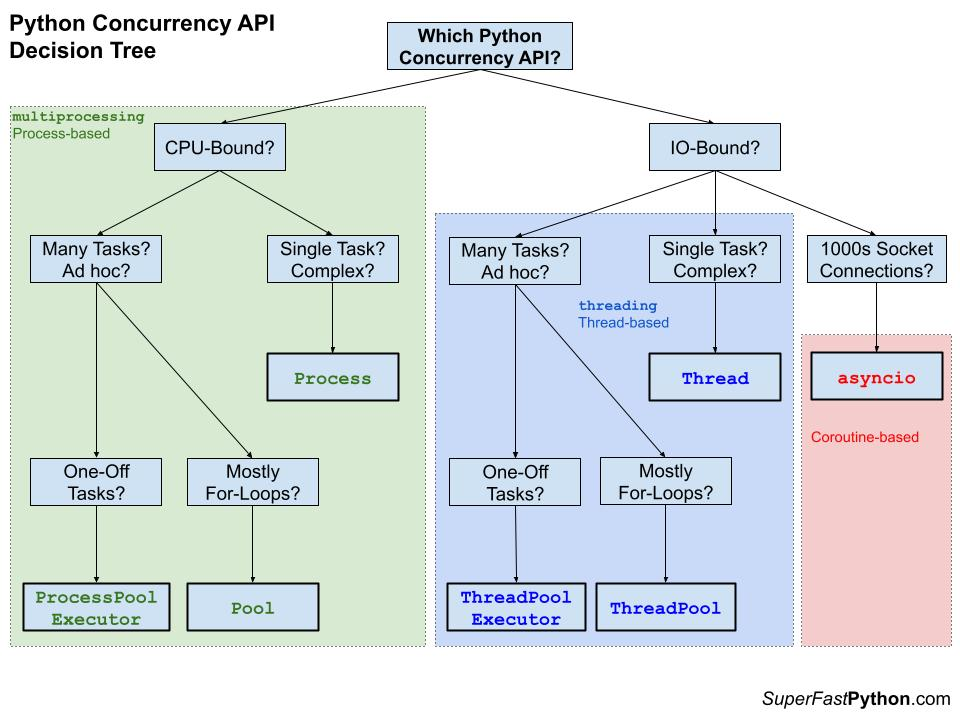

- CPU-Bound задачи, в которых в основном участвует процессор (считаем числа, обрабатываем тексты и тд) - берем multiprocessing
- IO-Bound задачи, в которых в основном участвует ввод/вывод данных (читаем файлы, запрашиваем API) - берем threading/asyncio





- Одна большая задача - делаем один процесс/тред, работаем с ним
- Много маленьких задач - нужен пул/воркеров
- ОЧЕНЬ много мелких задач - нужен asyncio

Также стоит учесть, что пул хорош для однородных задач

- Надо отменять задачи, работать с неоднородными задачками - воркеры
- Надо работать с исключениями, разными версиями map() - пулы
- Не уверены - берите что душе угодно

# Микродз

## Задание 1

Используя любой из способов, представленных в лекции, прочитайте файлы быстрее, чем это делается функцией slow_read_files() .

In [73]:
!ls -la

total 4708
drwxr-xr-x 1 root root       4096 Nov 20 17:24 .
drwxr-xr-x 1 root root       4096 Nov 20 15:01 ..
-rw-r--r-- 1 root root          0 Nov 20 16:04 async_dog1.jpg
-rw-r--r-- 1 root root          0 Nov 20 16:04 async_dog2.jpg
drwxr-xr-x 4 root root       4096 Nov 17 14:29 .config
-rw-r--r-- 1 root root 1073741824 Nov 20 17:24 large_file_0
-rw-r--r-- 1 root root 1073741824 Nov 20 17:24 large_file_1
-rw-r--r-- 1 root root 1073741824 Nov 20 17:24 large_file_2
-rw-r--r-- 1 root root    1251993 Nov 20 15:40 ordinary_dog1.jpg
-rw-r--r-- 1 root root     344524 Nov 20 15:40 ordinary_dog2.jpg
-rw-r--r-- 1 root root    1251993 Nov 20 16:31 process_dog1.jpg
-rw-r--r-- 1 root root     344524 Nov 20 16:31 process_dog2.jpg
drwxr-xr-x 1 root root       4096 Nov 17 14:29 sample_data
-rw-r--r-- 1 root root    1251993 Nov 20 16:21 thread_dog1.jpg
-rw-r--r-- 1 root root     344524 Nov 20 16:21 thread_dog2.jpg


In [72]:
import os
import time

def gen_large_file(path):
  gb = 1024*1024*1024 # 1GB
  with open(path, "wb") as f:
    f.truncate(gb)

for i in range(3):
  gen_large_file(f"large_file_{i}")

In [74]:
def slow_read_files():
  start = time.time()
  for i in range(3):
    with open(f"large_file_{i}", "rb") as f:
      f.read()

  return time.time() - start

In [80]:
def fast_read_files():
  start = time.time()

  # тут ваш код
  time.sleep(5) # потом убрать

  return time.time() - start

In [81]:
assert fast_read_files() < slow_read_files()

AssertionError: 

## Задание 2

Ранее в лекции мы смотрели, как можно организовать взаимодействие сервера и клиентов. Доработайте этот код, чтоб:
- клиенты начали читать только после того, как все значения окажутся в очереди to_me
- клиенты посылали на сервер результаты вычислений
- сервер отработал до того момента, пока не прочитает все результаты, после чего завершает работу
- клиенты завершают работу после того, как сервер все прочитал

In [ ]:
import queue

class Client():
  def __init__(self, name, to_me):
    self.name = name
    self.to_me = to_me
    # сюда надо что-то дописать

  def process(self):
    # сюда надо что-то дописать
    while True:
      val = self.to_me.get()
      self.to_me.task_done()
      res = val**2
      print(f"{self.name} res={res}")

class Server():
  def __init__(self, from_me):
    self.from_me = from_me

    self.results = []
    # сюда надо что-то дописать

  def process(self):
    for i in range(10):
      time.sleep(1)
      self.from_me.put(i)
    # сюда надо что-то дописать

In [ ]:
# возможно, что вам надо будет что-то еще создать и передать при создании сервера и клиентов
q = queue.Queue()
s = Server(q)
c1 = Client("client 1", q)
c2 = Client("client 2", q)

# все, что дальше, трогать не надо
threads = [threading.Thread(target=s.process),
           threading.Thread(target=c1.process),
           threading.Thread(target=c2.process),
           ]

for thread in threads:
  thread.start()

for thread in threads:
  thread.join() # ждем окончания

assert set(s.results) == set([0,1,4,9,16,25,36,49,64,81])